# Digit Classification: Classification with Convolutional Neural Network

<br />
<br />
<br />

### Table of Contents

* Introduction

* Load Data

* Convolutional Neural Network
 * Background on Neural Netowrks
 * Background on Convolutional Neural Networks
 * Application of Neural Network to Digit Classification
 * Training and Evaluating Model

* Exporting the Model
   * HDF5 Format
   * SavedModel Object
   
* Conclusion

<br />
<br />
<br />


# Introduction

This notebook illustrates the application of neural networks to a classification problem: identifying handwritten digits. The data set utilized is a [handwritten digits data set](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) provided by the [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets.html) repository and consists of 8x8 optical scans of handwritten digits, together with labels of the correct digit.

Applying neural networks to problems usually proceeds in a few steps, and begins with analyzing the features vector - the inputs to the problem. Techniques like PCA reduce the dimensionality of the problem and make linear models cheaper. Such dimensionality reduction can also be performed using neural networks, using an architecture where the network starts dense and becomes progressively narrower, then re-expands to the full dimensionality of the original data set. The first half of the network can then be used to reduce the dimensionality, and the second half used to find the back-projection of low dimensional points to higher dimensional space. (In another notebook, we used this technique to explore the lower dimensional space and how it tied in with the topology of the handwritten digits.)

Once the dimensionality of the original data set is reduced (if so desired), a neural network for classification can be built to map the input vectors to their corresponding classes.

This notebook utilizes the Keras library to build the neural network. [Keras Documentation](https://keras.io/) was, of course, immensely useful. [Tensorflow Documentation](https://www.tensorflow.org/) was also a big help.

In [12]:
%matplotlib inline

# numbers
import numpy as np
import pandas as pd
import tensorflow as tf

# stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# plots
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import seaborn as sns

# images
from IPython.display import Image

# utils
import os, re
from pprint import pprint


In [13]:
# learn you some machines
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.utils import np_utils

# Load Data

The data consists of an 8x8 grid of pixel intensities. We'll load the training and testing data, then normalize and scale them so that they have a mean of 0 and a variance of 1.

In [14]:
testing_df = pd.read_csv('data/optdigits/optdigits.tes',header=None)
X_testing,  y_testing  = testing_df.loc[:,0:63],  testing_df.loc[:,64]

training_df = pd.read_csv('data/optdigits/optdigits.tra',header=None)
X_training, y_training = training_df.loc[:,0:63], training_df.loc[:,64]

In [15]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    
    ## Automatic:
    #X_cov = np.cov(X_std.T)
    
    # Manual:
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

#X_std, X_mean, X_cov = get_normed_mean_cov(X_training)
X_train, _, _ = get_normed_mean_cov(X_training)
X_test, _, _ = get_normed_mean_cov(X_testing)

X_train = X_train.reshape(-1,8,8,1)
X_test = X_test.reshape(-1,8,8,1)

y_train = np_utils.to_categorical(y_training, 10)
y_test = np_utils.to_categorical(y_testing, 10)

In [16]:
print X_train.shape

(3823, 8, 8, 1)


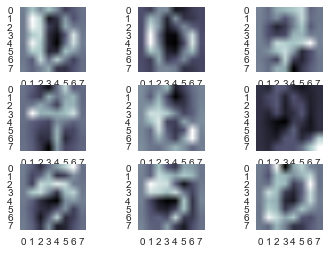

In [17]:
for i in range(9):
    plt.subplot(331+i)
    plt.imshow(X_train.reshape(-1,1,8,8)[i][0], cmap=cm.bone)
    gca().grid(False)
plt.show()
#print(y_test[1000:1009])

# Convolutional Neural Network

## Background on Neural Networks

First, let's clarify what a neural network is. "Neural network" is just a fancy term for a nonlinear parametric model. Neural networks consist of layers (groups) of perceptrons, which function similar to neurons in the brain, connected to one another with weighted connections, which function similar to synapses in the brain. The perceptrons can each have a certain vector of inputs $\mathbf{x}$ consisting of $d$ connections to other perceptrons. Each of these input values are weighted according to a vector of weights $\mathbf{w}$, which are the parameters in the model that are adjusted in the training process. As the network is trained, a good model will create a pathway from inputs to outputs, and the synapses along that pathway will be amplified and reinforced with more training.

### Single Perceptron Network Layer

For a network layer with a single perceptron, we have multiple inputs feeding into a single perceptron:

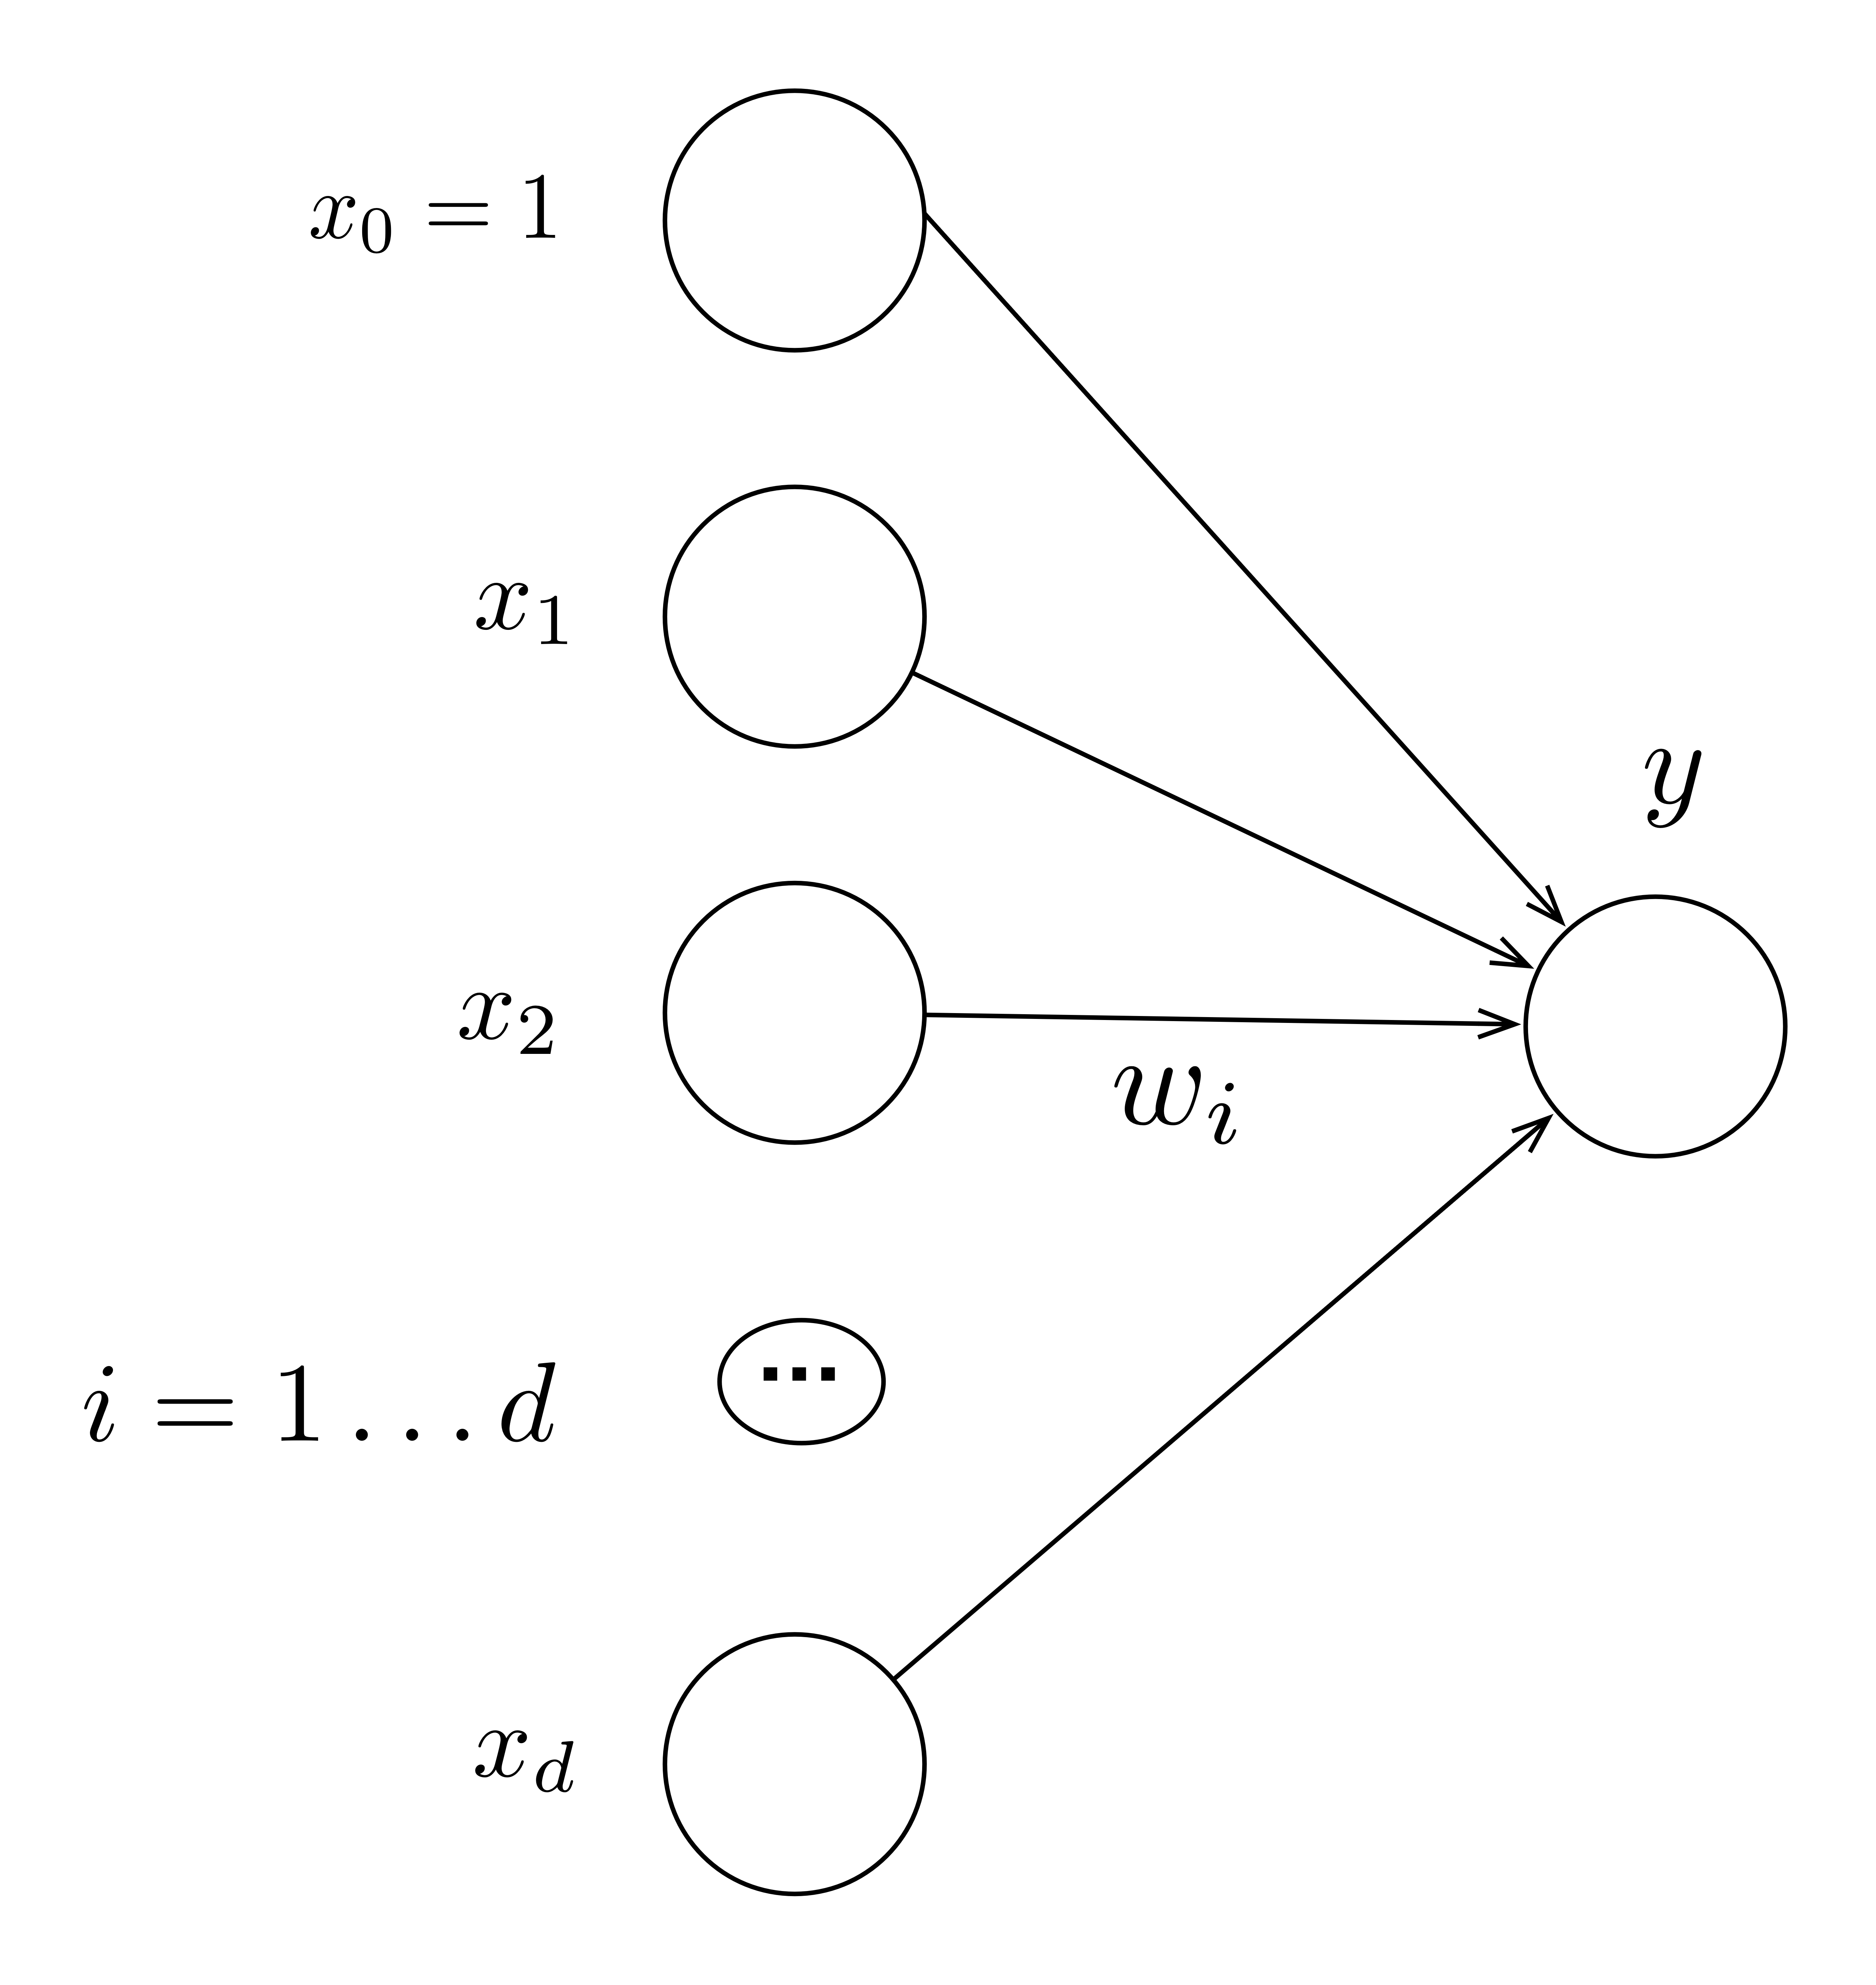

In [18]:
Image(filename='img/SinglePerceptron.png',width=400)

This neural network is a linear transformation of inputs $\mathbf{x}$ to the output $y$:

$$
y = \mathbf{w}^{T} \mathbf{x}
$$

or 

$$
y = \sum_{i=1}^{d} w_{i} x_{i} + w_0
$$

For an input vector of length $d$, a constant 1 term is added to make it length $d+1$, and the weights vector is also length $d+1$. A network consisting of a single layer is a linear transformation, regardless of number of perceptrons.

### Parallel Perceptrons

A network with multiple output perceptrons is still a linear transformation, but the scalar quantity $y$ is now a vector quantity $\mathbf{y}$ with length $k$, and the weights now form a $k \times d$ matrix:

$$
\mathbf{y} = \mathbf{W} \mathbf{x}
$$

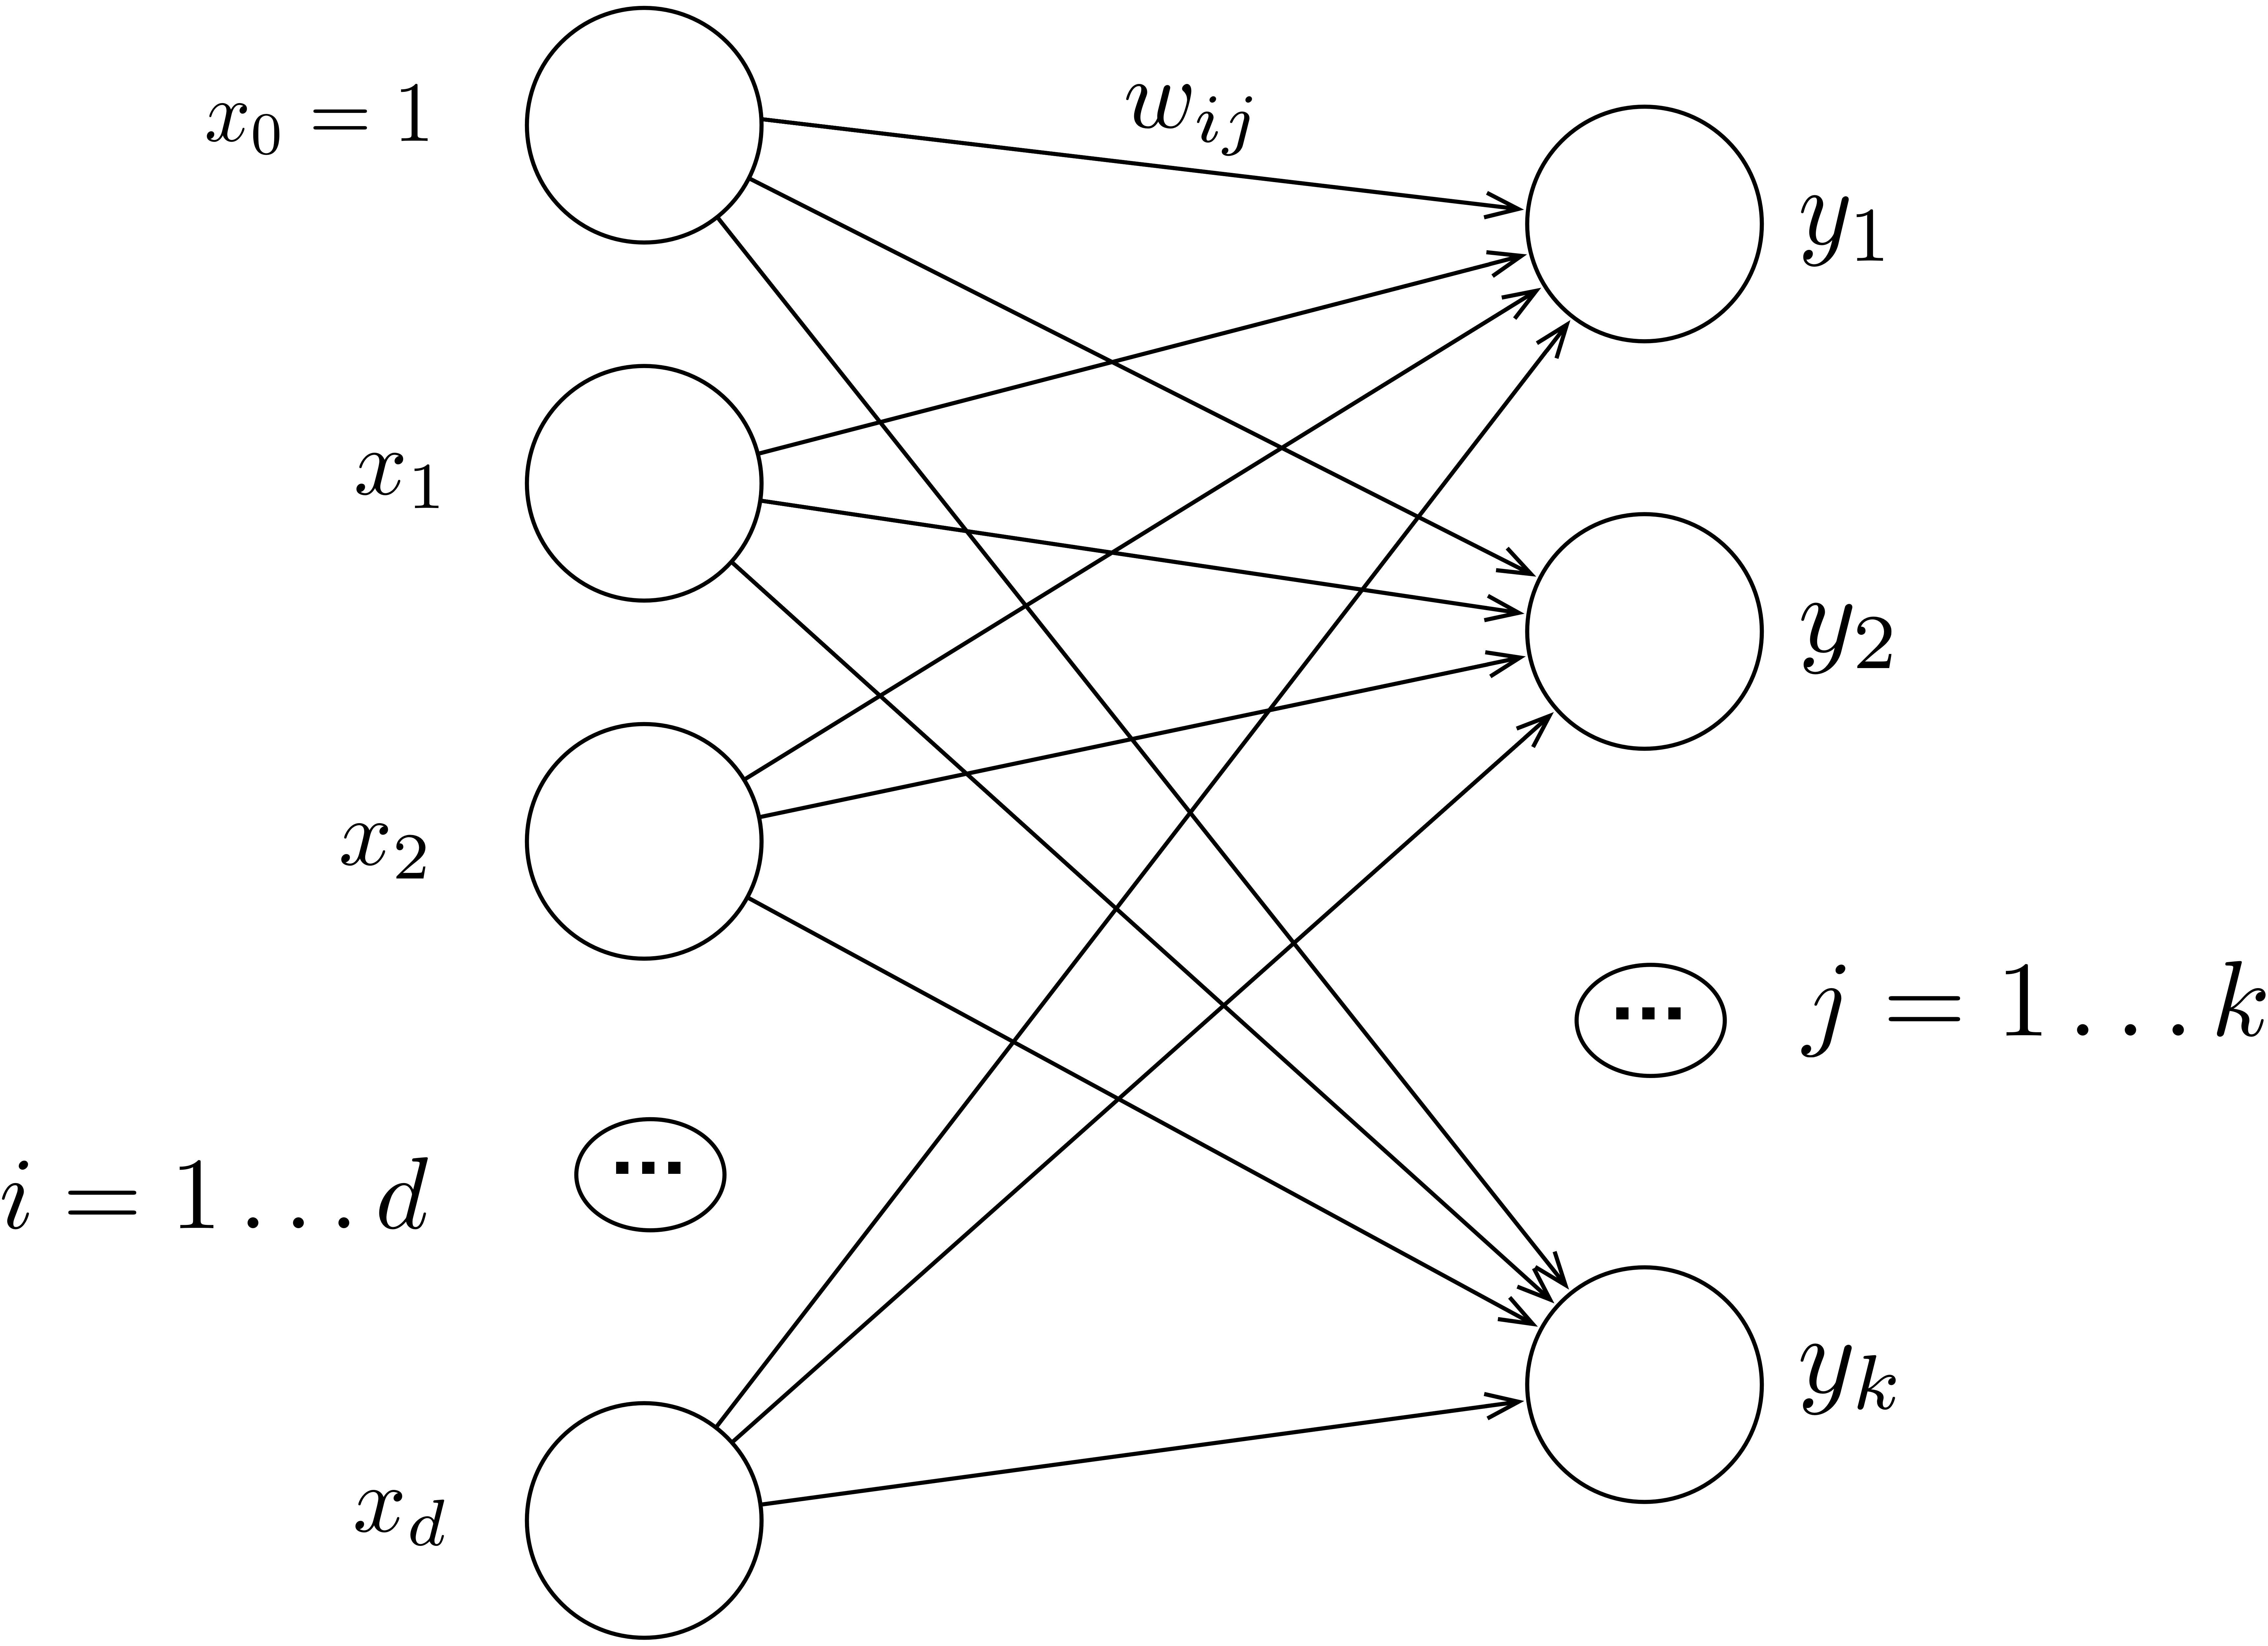

In [19]:
Image(filename='img/MultiPerceptron.png',width=400)

When training the network to perform a classification task, the last layer in the network should have as many nodes as we have classes. Then we can simply take the perceptron with the strongest signal as the class to which the set of inputs belongs.

## Background on Convolutional Neural Networks

The convolutional neural network is a type of feed-forward neural network inspired by the architecture of the visual cortex in animal brains. It is a good choice for simple image processing tasks like this one.

We start with a 2D convolutional neural network. The [Keras documentation]() defines the Convolution2D object as a "convolution operator for filtering windows of two-dimensional inputs." 

In plain English, we apply a convolution by running our data through a neural network with a particular structure to how the perceptrons (neurons) are connected. The convolution we are applying is two-dimensional, and we specify the number of perceptrons we want our network to use when we create it. 

The architecture of typical convolutional neural networks is:
* Convolution (first half of image)
* Convolution (second half of image)
* Pool (combine halves)
* Drop (filter information)
* Flatten 
* Dense
* Drop
* Dense

## Application of Neural Nets to Digit Classification

We'll use a 2D convolutional neural network of size 3x3, meaning we'll have 9 interconnected perceptrons. We feed that the first 32 elements of the input vector - the top half of the image. We create a second 2D convolutional neural network to process the bottom half of the image.

Our `input_shape` is 8x8x1, since we have a single 8x8 image that is grayscale (if it were color, we would have RGB values and an 8x8x3 input shape). 

We will apply a 3x3 convolution using `Convolution2D(32,3,3)`, and specify that it has 32 output filters. We also specify that our data is an 8x8 image. The rest of the input data (the other 32 elements) go into the second `Convolution2D` object, which also has 32 inputs.

The `MaxPooling2D` pool combines the outputs of these two together, and the `dim_ordering` matches the shape of the Convolution2D that we specified.

The first Dropout layer randomly sets 30% of the nodes to 0, so it is a more forgiving filter of the nodes. These are fed into a Flatten layer, which turns all the data into a 1D vector, and passes it to a Dense layer, which is a classic neural network layer with 128 perceptrons all interconnected. There is another Dropout layer which drops 50% of the nodes.

The final layer is a Dense layer of 10 perceptrons - as mentioned above, we need the last layer to contain as many perceptrons as we have categories. We use a "softmax" setting here so that we get the posterior probabilities.

In [20]:
# Convolutional architecture
# ~conv, conv, pool, drop, flatten, dense, drop, dense~
model = Sequential()

model.add(Convolution2D(32, 3, 3, input_shape=(8,8,1), 
                        activation='relu',
                        border_mode = 'valid')) # use this border_mode b/c not using Theano
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,2), dim_ordering='th')) # channel dimension/depth is dim 1 to match 32 x 3 x 3
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

We will run this neural network for a given number of epochs, and measure its accuracy by passing in the validation data we want to use when we fit the model. In addition to the many parameters we have for each layer of perceptrons, we have more parameters to set when we compile the model, related to the optimization process. 

Keras lets you define your own optimizer object, or use built-in optimizers. In this case we use [ADADELTA](https://arxiv.org/abs/1212.5701). 

In [21]:
num_epochs = 25
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

# Training Neural Network Model

We train the neural network model by adjusting the coefficients of the network to match our data. If we pass in a `validation_data` argument, we can also validate the model, and save out a metric of how accurate the model is.

In [22]:
hist = model.fit(X_train,y_train, batch_size=128, nb_epoch=num_epochs, 
                validation_data=(X_test,y_test))
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 3823 samples, validate on 1797 samples
Epoch 1/25
3823/3823 [==============================] - 3s - loss: 2.0579 - acc: 0.3220 - val_loss: 1.4982 - val_acc: 0.7980
Epoch 2/25
3823/3823 [==============================] - 2s - loss: 1.0736 - acc: 0.7102 - val_loss: 0.4882 - val_acc: 0.8887
Epoch 3/25
3823/3823 [==============================] - 2s - loss: 0.5216 - acc: 0.8517 - val_loss: 0.3065 - val_acc: 0.9121
Epoch 4/25
3823/3823 [==============================] - 2s - loss: 0.3885 - acc: 0.8815 - val_loss: 0.2430 - val_acc: 0.9288
Epoch 5/25
3823/3823 [==============================] - 2s - loss: 0.3092 - acc: 0.9077 - val_loss: 0.2016 - val_acc: 0.9388
Epoch 6/25
3823/3823 [==============================] - 2s - loss: 0.2689 - acc: 0.9228 - val_loss: 0.1747 - val_acc: 0.9466
Epoch 7/25
3823/3823 [==============================] - 2s - loss: 0.2240 - acc: 0.9359 - val_loss: 0.1603 - val_acc: 0.9477
Epoch 8/25
3823/3823 [==============================] - 2s - loss: 0.2209 - a

This achieves a 97.7% accuracy rate at predicting handwritten digits - fantastic! We can also plot the loss rate and accuracy rate at each epoch:

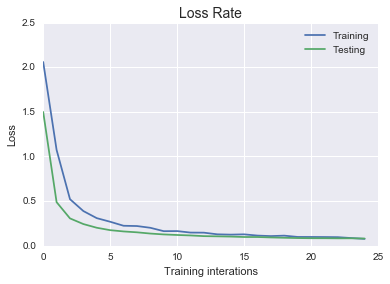

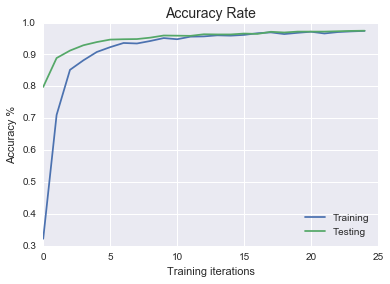

In [23]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Rate', size=14)
plt.ylabel('Loss')
plt.xlabel('Training interations')
plt.legend(['Training', 'Testing'], loc='upper right')
plt.show()
#plt.savefig('MNIST_loss_plot1.png')

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy Rate', size=14)
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Training','Testing'], loc='lower right')
plt.show()
#plt.savefig('MNIST_acc_plot1.png')

# Exporting the Model

Now that we've trained a neural network to classify handwriting digits, it would be really useful if we could actually use the model in something other than an iPython notebook.

Under the hood, each layer of perceptrons in the neural network is stored as a Tensorflow variable. To export the model for use the model in another language or program, then, we need to be able to export a tensor. A Tensorflow variable has a `graph` attribute that contains the necessary coefficients and other information, which we'll use to export the tensor. Here are the layers of perceptrons as Tensorflow variable objects:

In [24]:
print type(model)

<class 'keras.models.Sequential'>


In [25]:
print type(model.weights[0])

<class 'tensorflow.python.ops.variables.Variable'>


In [26]:
for i in range(len(model.weights)):
    print model.weights[i]

Tensor("convolution2d_1_W/read:0", shape=(3, 3, 1, 32), dtype=float32)
Tensor("convolution2d_1_b/read:0", shape=(32,), dtype=float32)
Tensor("convolution2d_2_W/read:0", shape=(3, 3, 32, 32), dtype=float32)
Tensor("convolution2d_2_b/read:0", shape=(32,), dtype=float32)
Tensor("dense_1_W/read:0", shape=(288, 128), dtype=float32)
Tensor("dense_1_b/read:0", shape=(128,), dtype=float32)
Tensor("dense_2_W/read:0", shape=(128, 10), dtype=float32)
Tensor("dense_2_b/read:0", shape=(10,), dtype=float32)


### Export Formats

There are three ways to do this:
* HDF5 - this is mainly intended for saving and loading from and to keras/theano, not exporting for evluation in another language.
* SavedModel object - promising, but confusing syntax. This is intended for exporting to another language.
* freeze_graph script - more questionable, but less new. Also has confusing syntax.

SavedModel object links:

* [Here](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/python/saved_model) is the SavedModel object, which is designed to be an exportable, language-agnostic format for the neural network model.

* [Here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/saved_model/saved_model_test.py) is a test of the SavedModel object, which illustrates how to make a varaible with a name, then how to save it in a few different ways. (This example shows that all of the confusing syntax is apparnetly arbitrary.)

Freeze graph script links:

* [Here](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/freeze_graph.py) is the freeze_graph tool in the Tensorflow github repo. This is what you use to store the Tensorflow tensor.

* [Here](https://medium.com/@hamedmp/exporting-trained-tensorflow-models-to-c-the-right-way-cf24b609d183#.i9p7o6bcw) is a guide to exporting Tensorflow objects to a C++ code that can the neural network with a given input. This uses the freeze_graph script above.

### Method 1: HDF5

In [27]:
model.save('nn.hdf5')

### Method 2: SavedModel Object

To save this as a SavedModel Object, I followed [this test](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/saved_model/saved_model_test.py) of the SavedModel object in the Tensorflow repository, together with exploration of Tensorflow objects and the documentation. These I/O statements came from the test, and are useful for exporting to a SavedModel object:

In [28]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.lib.io import file_io
from tensorflow.python.framework import ops

Now take a look at this Keras model. We already saw the field `weights` is a list of Tensorflow variables. We can extract the name of each variable (the name of the neural network layer automatically assigned by Keras) and the graph object representing that tensor:

In [29]:
for f in (type(model.weights[0]), 
          dir(model.weights[0]), 
          model.weights[0].name, 
          model.weights[0].graph,
          model.weights[0].value()):
    print "-"*20
    print f

--------------------
<class 'tensorflow.python.ops.variables.Variable'>
--------------------
['SaveSliceInfo', '_AsTensor', '_OverloadAllOperators', '_OverloadOperator', '_TensorConversionFunction', '__abs__', '__add__', '__and__', '__array_priority__', '__class__', '__delattr__', '__dict__', '__div__', '__doc__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__invert__', '__iter__', '__le__', '__lt__', '__mod__', '__module__', '__mul__', '__neg__', '__new__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_as_graph_element', '_caching_device', '_get_save_slice_info', '_init_from_args', '_init_from_proto', '_initial_value', '_initializer_op', '_keras_initial

Now we set an export directory for the SavedModel builder. This complains/fails if the directory already exists.

In [30]:
export_dir = 'export1'
file_io.delete_recursively( export_dir )
builder = saved_model_builder.SavedModelBuilder(export_dir)

Now we can export a graph by adding it to the SavedModellBuilder. Start with one graph.

This is where the syntax got a bit confusing. The documentation says the `signature_def_map` and `assets_collection` arguments are required for the `add_meta_graph_and_variables` method, and the user must provide them, but there is no information given about what an asset or a signature is. 

However, it turns out they aren't actually required.

I found this out by looking at the SavedModel test: see [the testTags method on line 110](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/saved_model/saved_model_test.py#L110). This method starts by calling a (private) method that will build a constant variable named "v" and add it to the graph. Then it calls `add_meta_graph_and_variables` and passes a session (which is initialized using our graph object) and a tag (which we can even skip specifying, and just use a few constant tags provided by the `tag_constants` class).

However, one thing that isn't so obvious from the test example is that you have to actually initialize the variables (not sure why they aren't initialized already, but if it works, it works).

In [31]:
myvar   = model.weights[0]
mygraph = model.weights[0].graph
myname  = model.weights[0].name

Getting the code below to run took some work. The code was initially complaining about the variable "Variable" not being initialized. Adding a call to `tf.initialize_all_variables()` fixed this problem:

```python
with tf.Session(graph=mygraph) as sess:
    sess.run( tf.initialize_all_variables() )
    builder.add_meta_graph_and_variables(sess, [myname])
builder.save()
```

While this fixed the problem, it also raised an error about `tf.initialize_all_variables()` being deprecated. Run `tf.global_variables_initializer()()` instead. The final code looks like this:

```python
with tf.Session(graph=mygraph) as sess:
    sess.run( tf.global_variables_initializer() )
    builder.add_meta_graph_and_variables(sess, [myname])
builder.save()
```

The following links were helpful in identifying this issue:
* [This](http://stackoverflow.com/questions/36763913/tensorflow-failedpreconditionerror-but-all-variables-have-been-initialized#36790650) issue with Tensorflow on Stack Overflow (gave me the clue about calling initialize all variables function)
* [This](https://www.tensorflow.org/how_tos/variables/) page on variables from the Tensorflow documentation, which mentioned the alternative way to initialize variables.

In [32]:
with tf.Session(graph=mygraph) as sess:
    sess.run( tf.global_variables_initializer() )
    builder.add_meta_graph_and_variables(sess, [myname])
builder.save()

INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: export1/saved_model.pb


INFO:tensorflow:SavedModel written to: export1/saved_model.pb


'export1/saved_model.pb'

### Limitations

It's not clear from the Tensorflow documentation or examples how to add multiple variables onto a single graph/session, so we're not going to do that. In fact, the HDF5 export option should give us exactly what we're looking for - it actually _includes_ all the details of the model, including the architecture and coefficients. 

As before, it might take some work to get those imported and running in another programming language, but at least it is exported and independent of Keras now.

# Conclusion

In this notebook, we loaded 8x8 bitmap images of handwritten digits, labeled with which digit they were, and built a convolutional neural network in Python using the Keras library to train it to classify the handwritten digits. We were able to demonstrate a simple neural network by itself - normally we would pair this kind of neural network with other methods to reduce the dimensionality or recover the posterior probability distributions for each class. 

We also showed how to export the neural network - this still requires some work to get it imported properly and working in another language, but it at least demonstrates the use of the SavedModel class and how to use it to save a single Tensorflow tensor, as well as an entire linked neural network.

# References

1. Alpaydin, Ethem. _Introduction to Machine Learning_, 2nd Edition. Cambridge, MA: MIT Press, 2010, ch. 11.